In [161]:
import os
import numpy as np
from PIL import Image
import torch
import pickle
import json
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

In [162]:
# Current working directory
cwd = os.getcwd()
print("Current Working Directory:", cwd)

# Base path
base_path = os.path.join(cwd, "datasets","data", "data", "muscima_split")

# Correct paths for train, val, and test splits
train_xml_directory = os.path.join(base_path, "train", "annotations")
train_img_directory = os.path.join(base_path, "train", "sheet_music")
train_output_path = os.path.join(base_path, "train", "bounding_boxes.pkl")

val_xml_directory = os.path.join(base_path, "val", "annotations")
val_img_directory = os.path.join(base_path, "val", "sheet_music")
val_output_path = os.path.join(base_path, "val", "bounding_boxes.pkl")

test_xml_directory = os.path.join(base_path, "test", "annotations")
test_img_directory = os.path.join(base_path, "test", "sheet_music")
test_output_path = os.path.join(base_path, "test", "bounding_boxes.pkl")

json_path = os.path.join(cwd,'MUSCIMA_class_splits.json')

model_pths = '/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths'

Current Working Directory: /Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer


In [ ]:
import os
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms

# Check if paths exist
for path in [train_output_path, val_output_path, test_output_path]:
    if not os.path.exists(path):
        print(f"File not found: {path}")
        raise FileNotFoundError(f"The file {path} does not exist. Check your paths.")

# Load bounding boxes
with open(train_output_path, 'rb') as f:
    train_bboxes = pickle.load(f)

with open(val_output_path, 'rb') as f:
    val_bboxes = pickle.load(f)

with open(test_output_path, 'rb') as f:
    test_bboxes = pickle.load(f)

# Extract the classes
def extract_classes_from_bboxes(bbox_dict):
    """
    Extract unique class labels from bounding box annotations.

    Args:
        bbox_dict (dict): Bounding box dictionary with filenames as keys and a list of bounding box annotations.

    Returns:
        list: Sorted list of unique class labels.
    """
    class_set = set()
    for filename, annotations in bbox_dict.items():
        if isinstance(annotations, list):
            for bbox in annotations:
                if isinstance(bbox, dict):
                    if 'className' in bbox:
                        class_set.add(bbox['className'])
                    elif 'label' in bbox:
                        class_set.add(bbox['label'])
                    else:
                        print(f"Warning: No 'class' or 'label' key found in bbox for {filename}: {bbox}")
                else:
                    print(f"Warning: Unexpected bbox format for {filename}: {bbox}")
        else:
            print(f"Warning: Unexpected annotations format for {filename}: {annotations}")
    return sorted(class_set)


classes = extract_classes_from_bboxes(train_bboxes)
print("Extracted Classes:", classes)
CLASSES_TO_IDX = {cls: idx for idx, cls in enumerate(classes)} if classes else None




Extracted Classes: ['accidentalDoubleSharp', 'accidentalFlat', 'accidentalNatural', 'accidentalSharp', 'arpeggio', 'articulationAccent', 'articulationStaccato', 'articulationTenuto', 'augmentationDot', 'barline', 'barlineHeavy', 'beam', 'brace', 'bracket', 'breathMark', 'cClef', 'characterCapitalA', 'characterCapitalC', 'characterCapitalE', 'characterCapitalF', 'characterCapitalL', 'characterCapitalM', 'characterCapitalP', 'characterCapitalR', 'characterCapitalS', 'characterCapitalT', 'characterCapitalV', 'characterDot', 'characterOther', 'characterSmallA', 'characterSmallB', 'characterSmallC', 'characterSmallD', 'characterSmallE', 'characterSmallF', 'characterSmallG', 'characterSmallI', 'characterSmallJ', 'characterSmallL', 'characterSmallM', 'characterSmallN', 'characterSmallO', 'characterSmallP', 'characterSmallR', 'characterSmallS', 'characterSmallT', 'characterSmallU', 'characterSmallV', 'characterSmallX', 'characterSmallZ', 'dottedHorizontalSpanner', 'dynamicCrescendoHairpin', 'd

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from PIL import Image
import json
import math

# -------------------------
# Dataset Class
# -------------------------
class DirectoryIteratorWithBoundingBoxes(Dataset):
    def __init__(self, directory, bounding_boxes=None, target_size=(256, 256),
                 transform=None, classes=None, class_to_idx=None):
        self.directory = directory
        self.bounding_boxes = bounding_boxes
        self.target_size = target_size
        self.transform = transform
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.filenames = [os.path.join(root, file) 
                          for root, _, files in os.walk(directory) 
                          for file in files if file.lower().endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load image
        img_path = self.filenames[idx]
        img = Image.open(img_path).convert("RGB")
        orig_w, orig_h = img.size  # Original image size

        # Resize image
        img = img.resize(self.target_size)
        if self.transform:
            img = self.transform(img)

        # Load and scale bounding boxes
        file_name = os.path.basename(img_path)
        bboxes = []
        labels = []

        if file_name in self.bounding_boxes:
            for bbox in self.bounding_boxes[file_name]:
                x, y, w, h = bbox['origin']['x'], bbox['origin']['y'], bbox['width'], bbox['height']
                class_name = bbox['className']

                # Scale bounding boxes to resized image size
                scale_x = self.target_size[0] / orig_w
                scale_y = self.target_size[1] / orig_h
                x = x * scale_x
                y = y * scale_y
                w = w * scale_x
                h = h * scale_y

                bboxes.append([x, y, w, h])
                labels.append(self.class_to_idx[class_name])

        bboxes = torch.tensor(bboxes, dtype=torch.float32)  # [num_boxes, 4]
        labels = torch.tensor(labels, dtype=torch.long)  # [num_boxes]
        return img, (labels, bboxes)




In [165]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize Datasets
train_dataset = DirectoryIteratorWithBoundingBoxes(
    directory=train_img_directory,
    bounding_boxes=train_bboxes,
    target_size=(256, 256),
    transform=transform,
    classes=classes,
    class_to_idx = CLASSES_TO_IDX
)

val_dataset = DirectoryIteratorWithBoundingBoxes(
    directory=val_img_directory,
    bounding_boxes=val_bboxes,
    target_size=(256, 256),
    transform=transform,
    classes=classes,
    class_to_idx = CLASSES_TO_IDX
)

test_dataset = DirectoryIteratorWithBoundingBoxes(
    directory=test_img_directory,
    bounding_boxes=test_bboxes,
    target_size=(256, 256),
    transform=transform,
    classes=classes,
    class_to_idx = CLASSES_TO_IDX
)


In [166]:
!pip install torcheval

VGG-based pretrained backbone, anchor-based localization, Focal Loss for classification, and Smooth L1 Loss for regression.

In [167]:
from torchvision.models import vgg16

# -------------------------
class VGGWithLocalization(nn.Module):
    def __init__(self, num_classes, num_anchors=3):
        super(VGGWithLocalization, self).__init__()
        # Load pretrained VGG16 backbone
        vgg_backbone = vgg16(pretrained=True).features
        self.feature_extractor = nn.Sequential(*list(vgg_backbone.children())[:-1])

        # Heads
        self.classification_head = nn.Conv2d(512, num_classes * num_anchors, kernel_size=3, padding=1)
        self.regression_head = nn.Conv2d(512, 4 * num_anchors, kernel_size=3, padding=1)

    def forward(self, x):
        features = self.feature_extractor(x)
        class_preds = self.classification_head(features)  # [B, num_classes*num_anchors, H, W]
        bbox_preds = self.regression_head(features)       # [B, 4*num_anchors, H, W]
        return class_preds, bbox_preds



In [168]:
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
# -------------------------
# Utility Functions
# -------------------------
def class_counts(dataset):
    class_counts = Counter()
    for _, (labels, _) in dataset:
        class_counts.update(labels.numpy())
    return class_counts
def compute_class_weights(dataset, num_classes):
    """
    Compute class weights inversely proportional to class frequencies.
    Args:
        dataset: PyTorch Dataset object
        num_classes: Total number of classes
    Returns:
        Tensor containing weights for each class
    """
    class_counts = Counter()
    for _, (labels, _) in dataset:
        for label in labels:
            class_counts[label.item()] += 1  # Count occurrences of each class

    total_samples = sum(class_counts.values())
    weights = [total_samples / (class_counts[i] if i in class_counts else 1) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float32)


def evaluate_metrics(preds, targets, num_classes):
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    present_classes = set(targets.flatten()) - {0}
    precision = precision_score(targets, preds, labels=list(present_classes), average='weighted', zero_division=0)
    recall = recall_score(targets, preds, labels=list(present_classes), average='weighted', zero_division=0)
    f1 = f1_score(targets, preds, labels=list(present_classes), average='weighted', zero_division=0)
    return precision, recall, f1


In [169]:
# -------------------------
# Focal Loss and Smooth L1 Loss
# -------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        ce_loss = F.cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [170]:
def custom_collate_fn(batch):
    """
    Custom collate function for variable-length bounding boxes and labels.
    Args:
        batch: List of tuples (image, (labels, bboxes)).
    Returns:
        images: Tensor of stacked images.
        targets: Tuple of lists (labels, bboxes) for each image.
    """
    images = []
    all_labels = []
    all_bboxes = []

    for img, (labels, bboxes) in batch:
        images.append(img)  # Add image
        all_labels.append(labels)  # Add labels (variable length)
        all_bboxes.append(bboxes)  # Add bboxes (variable length)

    # Stack images into a single tensor
    images = torch.stack(images, dim=0)

    # Return images and a tuple of lists (labels, bboxes)
    return images, (all_labels, all_bboxes)


In [171]:
from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(
        [1.0 / len(train_dataset) for _ in range(len(train_dataset))],
        num_samples=len(train_dataset),
        replacement=True
    )


# Use the sampler in DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

In [172]:
def train_model(model, train_loader, val_loader, device, num_classes, num_anchors=3, num_epochs=30, lr=0.001, save_path="model.pth"):
    """
    Train the VGG model with localization and compute class and bounding box losses.
    Includes training and validation phases.

    Args:
        model: The model to train.
        train_loader: DataLoader for training set.
        val_loader: DataLoader for validation set.
        device: Device ('cuda' or 'cpu').
        num_classes: Total number of classes.
        num_anchors: Number of anchor boxes per grid cell.
        num_epochs: Number of training epochs.
        lr: Learning rate.
        save_path: Path to save the best model.
    """
    # Compute class weights
    class_weights = compute_class_weights(train_loader.dataset, num_classes).to(device)

    # Loss functions
    classification_criterion = nn.CrossEntropyLoss(weight=class_weights)
    localization_criterion = nn.SmoothL1Loss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)
    best_val_loss = float('inf')

    train_class_losses = []
    train_loc_losses = []
    val_class_losses = []
    val_loc_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_class_loss, total_train_loc_loss = 0, 0

        for images, (all_labels, all_bboxes) in train_loader:
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass
            class_preds, bbox_preds = model(images)  # Outputs from the model
            B, _, H, W = class_preds.shape

            # Initialize ground-truth targets
            class_targets = torch.zeros((B, H, W), dtype=torch.long, device=device)
            bbox_targets = torch.zeros((B, 4, H, W), dtype=torch.float, device=device)

            # Populate targets
            for b in range(B):
                for label, bbox in zip(all_labels[b], all_bboxes[b]):
                    x, y, w, h = bbox.int()
                    x1, x2 = max(0, x), min(W, x + w)
                    y1, y2 = max(0, y), min(H, y + h)
                    if x1 < x2 and y1 < y2:
                        class_targets[b, y1:y2, x1:x2] = label
                        bbox_targets[b, :, y1:y2, x1:x2] = torch.tensor([x, y, w, h], device=device).view(4, 1, 1)

            # Reshape predictions and targets for classification loss
            class_preds = class_preds.view(B, num_anchors, num_classes, H, W)  # [B, num_anchors, num_classes, H, W]
            class_preds = class_preds.permute(0, 3, 4, 1, 2).contiguous()     # [B, H, W, num_anchors, num_classes]
            class_preds = class_preds.view(-1, num_classes)                   # Flatten predictions

            class_targets = class_targets.unsqueeze(1).expand(-1, num_anchors, -1, -1)  # [B, num_anchors, H, W]
            class_targets = class_targets.permute(0, 2, 3, 1).contiguous()              # [B, H, W, num_anchors]
            class_targets = class_targets.view(-1)                                      # Flatten targets

            # Reshape predictions and targets for localization loss
            bbox_preds = bbox_preds.view(B, num_anchors, 4, H, W)  # [B, num_anchors, 4, H, W]
            bbox_preds = bbox_preds.permute(0, 3, 4, 1, 2).contiguous()  # [B, H, W, num_anchors, 4]
            bbox_preds = bbox_preds.view(-1, 4)  # Flatten predictions

            bbox_targets = bbox_targets.unsqueeze(1).expand(-1, num_anchors, -1, -1, -1)  # [B, num_anchors, 4, H, W]
            bbox_targets = bbox_targets.permute(0, 3, 4, 1, 2).contiguous()               # [B, H, W, num_anchors, 4]
            bbox_targets = bbox_targets.view(-1, 4)                                       # Flatten targets

            # Compute losses
            class_loss = classification_criterion(class_preds, class_targets)
            loc_loss = localization_criterion(bbox_preds, bbox_targets)

            # Combine losses
            loss = class_loss + loc_loss
            loss.backward()
            optimizer.step()

            total_train_class_loss += class_loss.item()
            total_train_loc_loss += loc_loss.item()



        print(f"Epoch {epoch+1} - Train Class Loss: {total_train_class_loss:.4f}, Train Loc Loss: {total_train_loc_loss:.4f}")
        train_class_losses.append(total_train_class_loss)
        train_loc_losses.append(total_train_loc_loss)

        # Validation Phase
        model.eval()
        total_val_class_loss, total_val_loc_loss = 0, 0

        with torch.no_grad():
            for images, (all_labels, all_bboxes) in val_loader:
                images = images.to(device)

                # Forward pass
                class_preds, bbox_preds = model(images)
                B, _, H, W = class_preds.shape

                # Initialize ground-truth targets
                class_targets = torch.zeros((B, H, W), dtype=torch.long, device=device)
                bbox_targets = torch.zeros((B, 4, H, W), dtype=torch.float, device=device)

                # Populate targets
                for b in range(B):
                    for label, bbox in zip(all_labels[b], all_bboxes[b]):
                        x, y, w, h = bbox.int()
                        x1, x2 = max(0, x), min(W, x + w)
                        y1, y2 = max(0, y), min(H, y + h)
                        if x1 < x2 and y1 < y2:
                            class_targets[b, y1:y2, x1:x2] = label
                            bbox_targets[b, :, y1:y2, x1:x2] = torch.tensor([x, y, w, h], device=device).view(4, 1, 1)

                # Reshape predictions and targets for classification loss
                class_preds = class_preds.view(B, num_anchors, num_classes, H, W)
                class_preds = class_preds.permute(0, 3, 4, 1, 2).contiguous()
                class_preds = class_preds.view(-1, num_classes)

                class_targets = class_targets.unsqueeze(1).expand(-1, num_anchors, -1, -1)
                class_targets = class_targets.permute(0, 2, 3, 1).contiguous()
                class_targets = class_targets.view(-1)

                # Reshape predictions and targets for localization loss
                bbox_preds = bbox_preds.view(B, num_anchors, 4, H, W)
                bbox_preds = bbox_preds.permute(0, 3, 4, 1, 2).contiguous()
                bbox_preds = bbox_preds.view(-1, 4)

                bbox_targets = bbox_targets.unsqueeze(1).expand(-1, num_anchors, -1, -1, -1)
                bbox_targets = bbox_targets.permute(0, 3, 4, 1, 2).contiguous()
                bbox_targets = bbox_targets.view(-1, 4)

                # Compute losses
                class_loss = classification_criterion(class_preds, class_targets)
                loc_loss = localization_criterion(bbox_preds, bbox_targets)

                total_val_class_loss += class_loss.item()
                total_val_loc_loss += loc_loss.item()

        avg_val_loss = total_val_class_loss + total_val_loc_loss
        print(f"Epoch {epoch+1} - Val Class Loss: {total_val_class_loss:.4f}, Val Loc Loss: {total_val_loc_loss:.4f}, Val Total Loss: {avg_val_loss:.4f}")
        val_class_losses.append(total_val_class_loss)
        val_loc_losses.append(total_val_loc_loss)


        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model at epoch {epoch+1}")

    print(f"Training Complete. Best Validation Loss: {best_val_loss:.4f}")
    return train_class_losses, train_loc_losses, val_class_losses, val_loc_losses


In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(len(classes))
model = VGGWithLocalization(num_classes=len(classes))
num_epochs=30
lr=0.001
name = f'vgg16_e{num_epochs}_lr{lr}.pth'
save_path = os.path.join(model_pths, name)
train_class_losses, train_loc_losses, val_class_losses, val_loc_losses = train_model(model, train_loader, val_loader, device, num_classes=len(classes), num_epochs=num_epochs, lr=lr, save_path=save_path)



115


/Users/costanzasiniscalchi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/costanzasiniscalchi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 - Train Class Loss: 8.6753, Train Loc Loss: 14.5528
Epoch 1 - Val Class Loss: 0.1599, Val Loc Loss: 0.1834, Val Total Loss: 0.3433
Saved best model at epoch 1
Epoch 2 - Train Class Loss: 0.2624, Train Loc Loss: 0.7713
Epoch 2 - Val Class Loss: 0.0114, Val Loc Loss: 0.0207, Val Total Loss: 0.0321
Saved best model at epoch 2
Epoch 3 - Train Class Loss: 0.0238, Train Loc Loss: 0.0926
Epoch 3 - Val Class Loss: 0.0017, Val Loc Loss: 0.0047, Val Total Loss: 0.0063
Saved best model at epoch 3
Epoch 4 - Train Class Loss: 0.0045, Train Loc Loss: 0.0225
Epoch 4 - Val Class Loss: 0.0002, Val Loc Loss: 0.0012, Val Total Loss: 0.0013
Saved best model at epoch 4
Epoch 5 - Train Class Loss: 0.0016, Train Loc Loss: 0.0078
Epoch 5 - Val Class Loss: 0.0002, Val Loc Loss: 0.0008, Val Total Loss: 0.0010
Saved best model at epoch 5
Epoch 6 - Train Class Loss: 0.0008, Train Loc Loss: 0.0045
Epoch 6 - Val Class Loss: 0.0001, Val Loc Loss: 0.0004, Val Total Loss: 0.0004
Saved best model at epoch 6
Epo

In [174]:
import pandas as pd
loss = [] 
for e in enumerate(zip(train_class_losses, train_loc_losses, val_class_losses, val_loc_losses)):
    print(e)
    loss.append(e)
# weight_decay=0.0005
# patience=5
import csv
csvfile = f'vgg16_e{num_epochs}_lr{lr}_losses.csv'
csvfile = os.path.join(model_pths, csvfile)
columns = ["Epoch", "train_class_losses", "train_loc_losses", "val_class_losses", "val_loc_losses"]
df = pd.DataFrame([(d[0], *d[1]) for d in loss], columns=columns)

# Saving the dataframe to a CSV file
df.to_csv(csvfile, index=False)

(0, (8.675253963563591, 14.552848279476166, 0.15989305078983307, 0.18344296514987946))
(1, (0.26236282545141876, 0.7713140826672316, 0.011360729113221169, 0.020730173215270042))
(2, (0.023759914620313793, 0.0925900163128972, 0.001650819438509643, 0.00465431297197938))
(3, (0.004503947464399971, 0.02252569783013314, 0.0001719755382509902, 0.0011739885667338967))
(4, (0.0016063133807620034, 0.0078120731632225215, 0.0001748743379721418, 0.0008179919677786529))
(5, (0.0007904162375780288, 0.004487516998779029, 5.027973747928627e-05, 0.0003775533114094287))
(6, (0.0003487913345452398, 0.0025538486370351166, 3.729335367097519e-05, 0.00022857110889162868))
(7, (0.00026947045262204483, 0.0016682288696756586, 2.6532990887062624e-05, 0.00015484265168197453))
(8, (0.00017816961189964786, 0.0010998062643921003, 1.815914765757043e-05, 0.00013118458446115255))
(9, (0.00012300809703447158, 0.0008680118626216426, 1.4093722711550072e-05, 8.552785584470257e-05))
(10, (9.813037922867807e-05, 0.0005504828

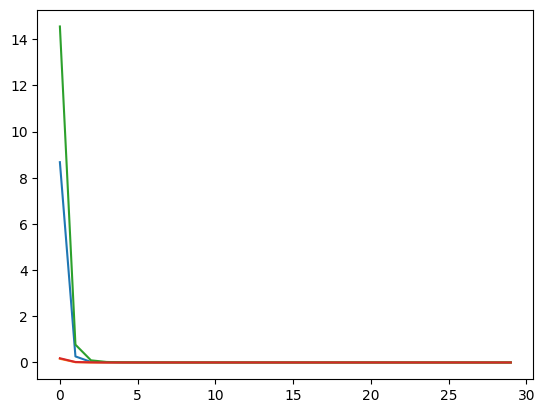

In [175]:
import matplotlib.pyplot as plt

plt.plot(train_class_losses, label = 'Training Class Losses')
plt.plot(val_class_losses, label = 'Validation Class Losses')
plt.plot(train_loc_losses, label = 'Training Location Losses')
plt.plot(val_loc_losses, label = 'Validation Location Losses')

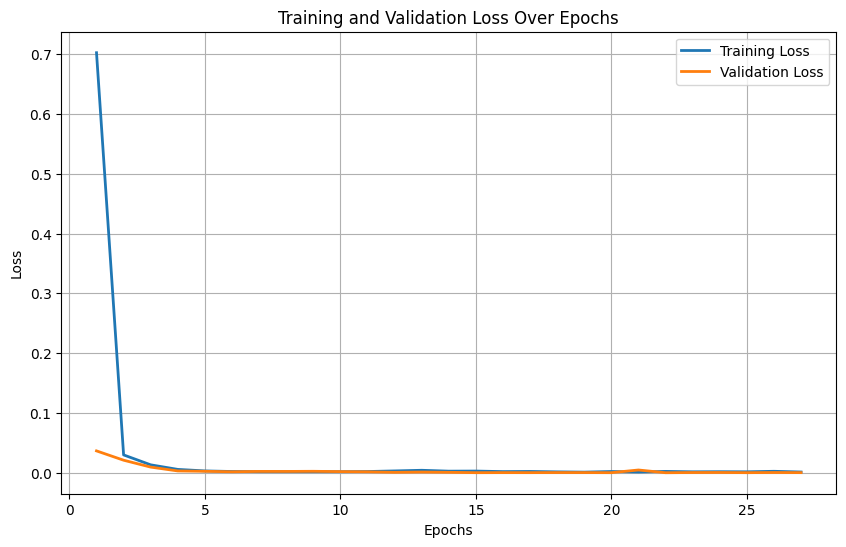

In [176]:
import json
import matplotlib.pyplot as plt

def plot_losses(metrics_path):
    """
    Plot training and validation losses over epochs.

    Parameters:
        metrics_path (str): Path to the JSON file containing train and val losses.
    """
    # Load metrics from JSON file
    with open(metrics_path, "r") as f:
        metrics = json.load(f)
    
    # Extract train and validation losses
    train_losses = metrics.get("train_class_loss", [])
    val_losses = metrics.get("val_class_loss", [])
    epochs = range(1, len(train_losses) + 1)
    
    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss", linewidth=2)
    plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)
    
    # Add plot details
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
metrics_path = '/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg4_lr0.1_wd0_metrics.json'
plot_losses(metrics_path)


In [177]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, data_loader, device, num_classes, num_anchors=3):
    """
    Evaluate the model on a given dataset and compute classification accuracy and localization error.

    Args:
        model: The trained model.
        data_loader: DataLoader for the evaluation dataset.
        device: Device ('cuda' or 'cpu').
        num_classes: Total number of classes.
        num_anchors: Number of anchor boxes per grid cell.

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    model.eval()
    total_correct = 0
    total_elements = 0
    total_loc_error = 0.0

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for images, (all_labels, all_bboxes) in data_loader:
            images = images.to(device)
            
            # Forward pass
            class_preds, bbox_preds = model(images)
            B, _, H, W = class_preds.shape

            # Reshape predictions for classification
            class_preds = class_preds.view(B, num_anchors, num_classes, H, W)  # [B, num_anchors, num_classes, H, W]
            class_preds = class_preds.permute(0, 3, 4, 1, 2).contiguous()     # [B, H, W, num_anchors, num_classes]
            class_preds = class_preds.view(-1, num_classes)                   # Flatten predictions

            # Reshape bounding box predictions
            bbox_preds = bbox_preds.view(B, num_anchors, 4, H, W)  # [B, num_anchors, 4, H, W]
            bbox_preds = bbox_preds.permute(0, 3, 4, 1, 2).contiguous()  # [B, H, W, num_anchors, 4]
            bbox_preds = bbox_preds.view(-1, 4)

            # Initialize targets
            class_targets = torch.zeros((B, H, W), dtype=torch.long, device=device)
            bbox_targets = torch.zeros((B, 4, H, W), dtype=torch.float, device=device)

            for b in range(B):
                for label, bbox in zip(all_labels[b], all_bboxes[b]):
                    x, y, w, h = bbox.int()
                    x1, x2 = max(0, x), min(W, x + w)
                    y1, y2 = max(0, y), min(H, y + h)
                    if x1 < x2 and y1 < y2:
                        class_targets[b, y1:y2, x1:x2] = label
                        bbox_targets[b, :, y1:y2, x1:x2] = torch.tensor([x, y, w, h], device=device).view(4, 1, 1)

            # Expand class_targets and bbox_targets to match anchors
            class_targets = class_targets.unsqueeze(1).expand(-1, num_anchors, -1, -1)
            class_targets = class_targets.permute(0, 2, 3, 1).contiguous().view(-1)

            bbox_targets = bbox_targets.unsqueeze(1).expand(-1, num_anchors, -1, -1, -1)
            bbox_targets = bbox_targets.permute(0, 3, 4, 1, 2).contiguous().view(-1, 4)

            # Get predicted class labels
            _, predicted_classes = torch.max(class_preds, dim=1)

            # Accuracy calculation
            correct = (predicted_classes == class_targets).sum().item()
            total_correct += correct
            total_elements += class_targets.numel()

            # Accumulate predictions and targets for additional metrics
            all_preds.extend(predicted_classes.cpu().numpy())
            all_targets.extend(class_targets.cpu().numpy())

            # Localization error (L1 loss)
            loc_error = torch.nn.functional.l1_loss(bbox_preds, bbox_targets, reduction='none')
            loc_error = loc_error.sum(dim=1)  # Sum over the 4 bbox coordinates
            total_loc_error += loc_error.sum().item()

    # Compute evaluation metrics
    accuracy = total_correct / total_elements
    mean_loc_error = total_loc_error / total_elements

    # Classification metrics
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    # Return metrics
    metrics = {
        "accuracy": accuracy,
        "mean_localization_error": mean_loc_error,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    print("\nEvaluation Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics


In [178]:
import torch
import os

def load_model(model_class, model_path, device, num_classes, num_anchors=3):
    """
    Load a saved model from a .pth file.

    Args:
        model_class: The class of the model architecture.
        model_path: Path to the .pth file.
        device: Device ('cuda' or 'cpu') to load the model.
        num_classes: Total number of classes.
        num_anchors: Number of anchor boxes per grid cell.

    Returns:
        The loaded model.
    """
    # Instantiate the model
    model = model_class(num_classes=num_classes, num_anchors=num_anchors).to(device)

    # Load the saved weights
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded successfully from {model_path}")
    else:
        raise FileNotFoundError(f"Model file not found: {model_path}")

    # Set model to evaluation mode
    model.eval()
    return model


# Paths and Device
model_pths = '/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths'
num_classes = len(classes)  # Ensure 'classes' is defined
model_name = "vgg16_e30_lr0.001.pth"  # Replace with your saved model name
model_path = os.path.join(model_pths, model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = load_model(VGGWithLocalization, model_path, device, num_classes=num_classes)

# Evaluate the model

print("\nEvaluating the model on the test set...")
test_metrics = evaluate_model(model, test_loader, device, num_classes=num_classes)


/Users/costanzasiniscalchi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/costanzasiniscalchi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully from /Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg16_e30_lr0.001.pth

Evaluating the model on the test set...

Evaluation Metrics:
accuracy: 1.0000
mean_localization_error: 0.0179
precision: 1.0000
recall: 1.0000
f1_score: 1.0000


In [179]:
import numpy as np

import torch
import numpy as np

def decode_bounding_boxes(pred_bboxes, feature_map_size, resized_size):
    """
    Decode raw predicted bounding boxes into image coordinates.

    Args:
        pred_bboxes: Raw predicted bounding boxes [N, 4] (center_x, center_y, width, height).
        feature_map_size: Tuple (H, W) of the feature map.
        resized_size: Tuple (resized_H, resized_W) of the resized image.

    Returns:
        Decoded bounding boxes as a list of [x, y, w, h].
    """
    decoded_boxes = []
    feature_h, feature_w = feature_map_size
    resized_h, resized_w = resized_size

    # Apply sigmoid to ensure bbox predictions are in [0, 1]
    pred_bboxes = torch.sigmoid(torch.tensor(pred_bboxes)).numpy()

    for box in pred_bboxes:
        cx, cy, w, h = box  # Predicted center_x, center_y, width, height (normalized)

        # Scale center_x and center_y to resized image dimensions
        cx = cx * resized_w
        cy = cy * resized_h

        # Scale width and height
        w = w * resized_w
        h = h * resized_h

        # Convert to (x, y, w, h) format
        x = max(0, cx - w / 2)
        y = max(0, cy - h / 2)
        w = min(resized_w, w)
        h = min(resized_h, h)

        decoded_boxes.append([x, y, w, h])

    return np.array(decoded_boxes)



def scale_bounding_boxes(bboxes, original_size, resized_size):
    """
    Scale bounding boxes from original image size to resized image size.

    Args:
        bboxes: List of bounding boxes [N, 4] in the format (x, y, w, h).
        original_size: Tuple (orig_H, orig_W) of the original image size.
        resized_size: Tuple (resized_H, resized_W) of the resized image size.

    Returns:
        Scaled bounding boxes in the same format [N, 4].
    """
    orig_h, orig_w = original_size
    resized_h, resized_w = resized_size

    scale_x = resized_w / orig_w
    scale_y = resized_h / orig_h

    scaled_bboxes = []
    for x, y, w, h in bboxes:
        x = x * scale_x
        y = y * scale_y
        w = w * scale_x
        h = h * scale_y
        scaled_bboxes.append([x, y, w, h])
    return scaled_bboxes


In [180]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(images, all_bboxes, all_labels, all_pred_bboxes, all_pred_labels, classes, original_sizes, resized_size=(256, 256), num_images=5):
    """
    Visualize images with ground truth and predicted bounding boxes and labels.

    Args:
        images: List of tensors representing resized images [C, H, W].
        all_bboxes: List of ground truth bounding boxes for each image (original size).
        all_labels: List of ground truth labels for each image.
        all_pred_bboxes: List of predicted bounding boxes for each image.
        all_pred_labels: List of predicted labels for each image.
        classes: List of class names.
        original_sizes: List of tuples [(orig_H, orig_W)] for each image.
        resized_size: Tuple (resized_H, resized_W) for the images.
        num_images: Number of images to visualize.
    """
    num_images = min(num_images, len(images))

    for i in range(num_images):
        # Convert the image to HWC format
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(img)
        ax.set_title("Ground Truth vs Predicted")

        # Scale and plot ground truth boxes
        scaled_bboxes = scale_bounding_boxes(all_bboxes[i], original_sizes[i], resized_size)
        for bbox, label in zip(scaled_bboxes, all_labels[i]):
            x, y, w, h = bbox
            rect = plt.Rectangle((x, y), w, h, fill=False, color="green", linewidth=2)
            ax.add_patch(rect)
            ax.text(x, y, f"GT: {classes[int(label)]}", color="green", fontsize=8, bbox=dict(facecolor="white", alpha=0.5))

        # Plot predicted boxes
        for bbox, label in zip(all_pred_bboxes[i], all_pred_labels[i]):
            x, y, w, h = bbox
            rect = plt.Rectangle((x, y), w, h, fill=False, color="red", linestyle="--", linewidth=2)
            ax.add_patch(rect)
            ax.text(x, y, f"Pred: {classes[int(label)]}", color="red", fontsize=8, bbox=dict(facecolor="white", alpha=0.5))

        plt.show()


In [184]:
def evaluate_model_with_visualization(model, data_loader, device, num_classes, classes, num_images_to_visualize=5, resized_size=(256, 256)):
    """
    Evaluate the model and visualize predictions with ground truth.

    Args:
        model: The trained model.
        data_loader: DataLoader for the evaluation dataset.
        device: Device ('cuda' or 'cpu').
        num_classes: Total number of classes.
        classes: List of class names.
        num_images_to_visualize: Number of images to visualize.
        resized_size: Tuple (resized_H, resized_W) for the images.
    """
    model.eval()
    images_to_visualize = []
    gt_bboxes_to_visualize = []
    gt_labels_to_visualize = []
    pred_bboxes_to_visualize = []
    pred_labels_to_visualize = []
    original_sizes = []

    with torch.no_grad():
        for batch_idx, (images, (all_labels, all_bboxes)) in enumerate(data_loader):
            images = images.to(device)

            # Save original sizes before resizing
            for bboxes in all_bboxes:
                orig_h, orig_w = 1000, 1000  # Default or dynamically tracked original size
                original_sizes.append((orig_h, orig_w))

            # Forward pass
            class_preds, bbox_preds = model(images)

            # Process predictions
            B, _, H, W = class_preds.shape  # Feature map size
            class_preds = class_preds.view(B, -1, num_classes)
            bbox_preds = bbox_preds.view(B, -1, 4)
            print(bbox_preds)
            print(all_bboxes)

            for b in range(B):
                # Append images
                images_to_visualize.append(images[b].cpu())

                # Ground truth (use original sizes for scaling)
                gt_bboxes_to_visualize.append(all_bboxes[b])
                gt_labels_to_visualize.append(all_labels[b])

                # Decode predictions
                decoded_bboxes = decode_bounding_boxes(bbox_preds[b].cpu().numpy(), (H, W), resized_size)
                pred_bboxes_to_visualize.append(decoded_bboxes)
                pred_labels_to_visualize.append(class_preds[b].argmax(dim=-1).cpu().numpy())

            if len(images_to_visualize) >= num_images_to_visualize:
                break

    # Visualize predictions
    visualize_predictions(
        images_to_visualize,
        gt_bboxes_to_visualize,
        gt_labels_to_visualize,
        pred_bboxes_to_visualize,
        pred_labels_to_visualize,
        classes,
        original_sizes=original_sizes,
        resized_size=resized_size,
        num_images=num_images_to_visualize
    )


In [ ]:
test_transform_notransform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize only, to match model input size
    transforms.ToTensor(),          # Convert to tensor for compatibility
])
test_dataset_notransform = DirectoryIteratorWithBoundingBoxes(
    directory=test_img_directory,
    bounding_boxes=test_bboxes,
    target_size=(256, 256),  # Resize target size
    transform=test_transform_notransform,  # Use the fixed transformation
    classes=classes,
    class_to_idx=CLASSES_TO_IDX
)

test_loader_notransform = DataLoader(
    test_dataset_notransform, 
    batch_size=16, 
    shuffle=False, 
    collate_fn=custom_collate_fn
)


tensor([[[-0.0353, -0.0141, -0.0198, -0.0277],
         [-0.0204, -0.0190, -0.0194, -0.0197],
         [-0.0201, -0.0203, -0.0204, -0.0190],
         ...,
         [ 0.0062,  0.0063,  0.0069,  0.0076],
         [ 0.0085,  0.0091,  0.0087,  0.0070],
         [ 0.0010,  0.0043, -0.0078,  0.0096]],

        [[-0.0349, -0.0141, -0.0199, -0.0274],
         [-0.0206, -0.0189, -0.0187, -0.0181],
         [-0.0175, -0.0173, -0.0174, -0.0159],
         ...,
         [ 0.0119,  0.0104,  0.0096,  0.0088],
         [ 0.0087,  0.0089,  0.0090,  0.0073],
         [ 0.0004,  0.0037, -0.0091,  0.0087]],

        [[-0.0358, -0.0121, -0.0199, -0.0280],
         [-0.0210, -0.0184, -0.0184, -0.0190],
         [-0.0197, -0.0202, -0.0204, -0.0188],
         ...,
         [ 0.0112,  0.0122,  0.0130,  0.0132],
         [ 0.0130,  0.0123,  0.0117,  0.0103],
         [ 0.0044,  0.0064, -0.0067,  0.0101]],

        ...,

        [[-0.0350, -0.0136, -0.0213, -0.0294],
         [-0.0225, -0.0203, -0.0198, -0.0196]

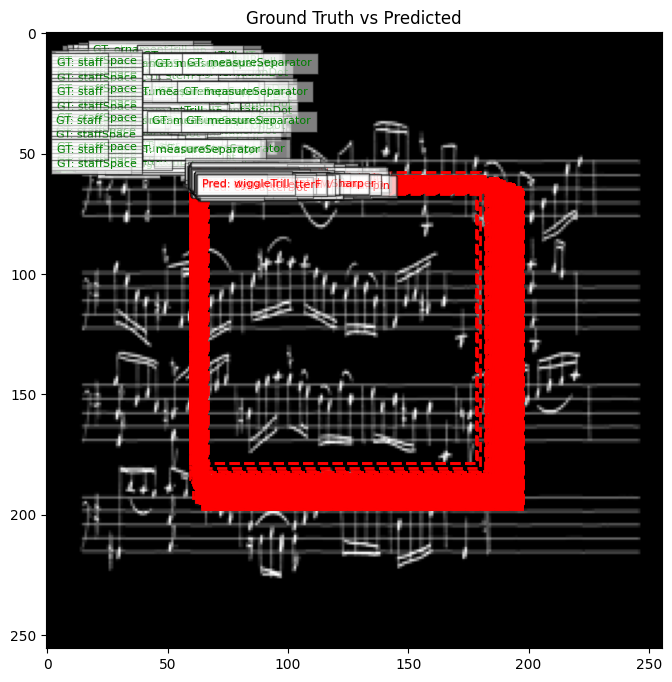

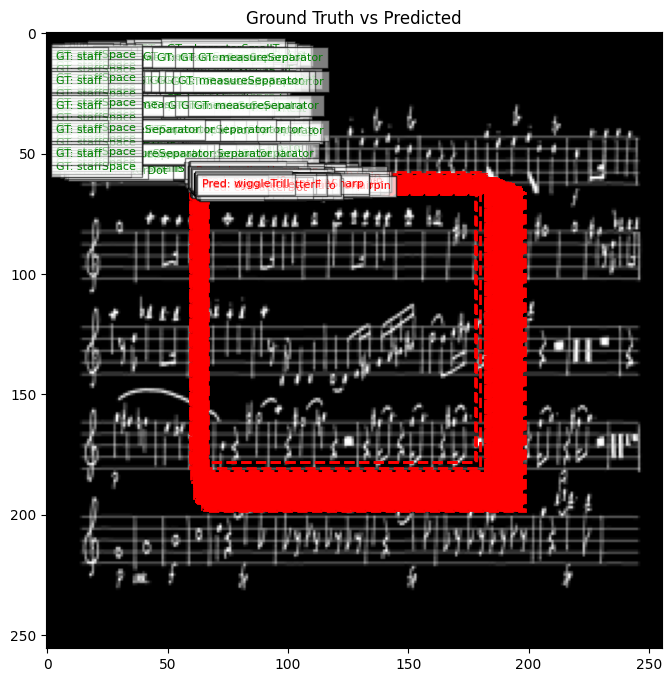

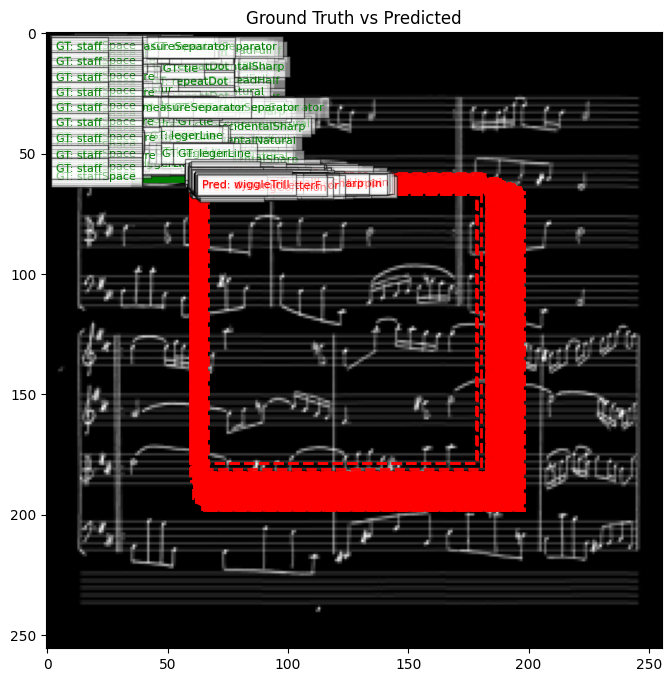

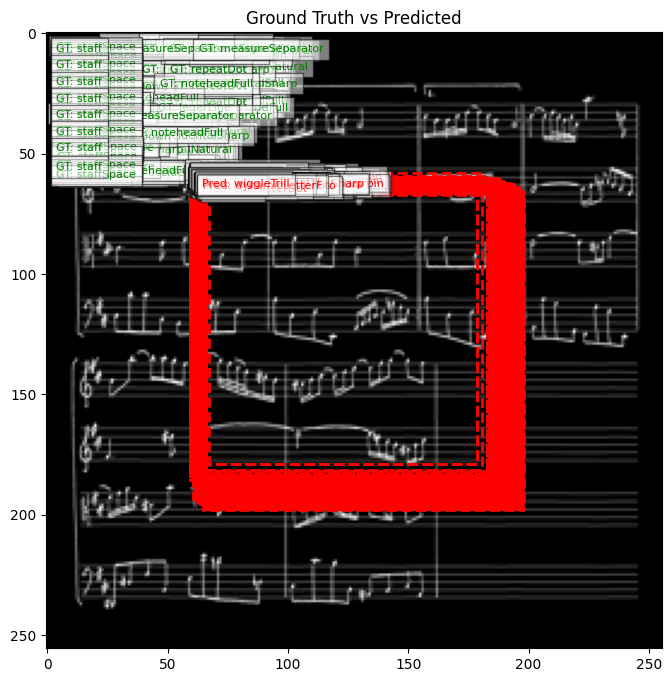

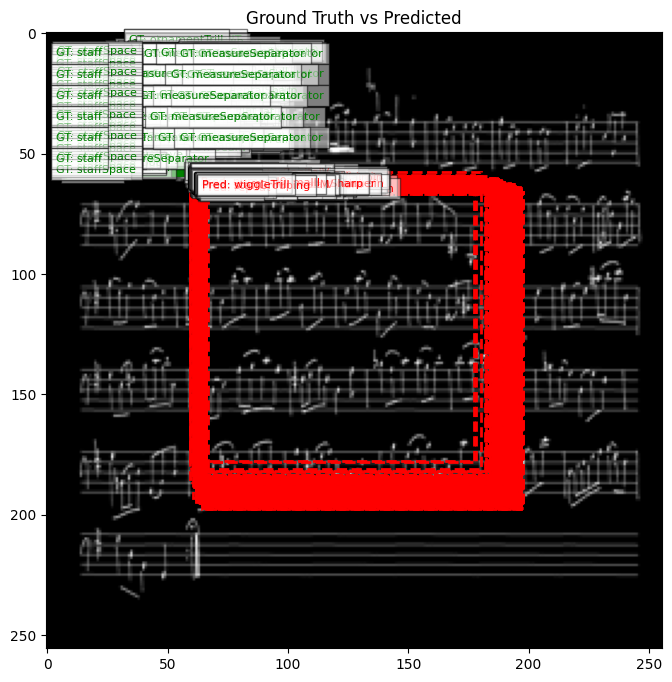

In [186]:
evaluate_model_with_visualization(
    model=model,
    data_loader=test_loader_notransform,
    device=device,
    num_classes=len(classes),
    classes=classes,
    num_images_to_visualize=5,
    resized_size=(256, 256)
)

In [230]:
import torch.nn.functional as F

def process_predictions(class_preds, bbox_preds, threshold=0.5):
    """
    Post-process predictions to extract boxes, labels, and scores.

    Args:
        class_preds: Tensor of shape (B, num_classes * num_anchors, H, W)
        bbox_preds: Tensor of shape (B, 4 * num_anchors, H, W)
        threshold: Confidence threshold to keep predictions.

    Returns:
        boxes: List of bounding boxes [x, y, w, h]
        labels: List of predicted class indices
        scores: List of confidence scores
    """
    B, _, H, W = class_preds.shape
    num_anchors = 3  # Set to the number of anchor boxes used

    # Reshape class predictions
    class_preds = class_preds.view(B, num_anchors, -1, H, W)  # [B, num_anchors, num_classes, H, W]
    class_preds = class_preds.permute(0, 3, 4, 1, 2).contiguous()  # [B, H, W, num_anchors, num_classes]
    class_preds = class_preds.view(B, -1, class_preds.shape[-1])  # Flatten

    # Reshape bounding box predictions
    bbox_preds = bbox_preds.view(B, num_anchors, 4, H, W)  # [B, num_anchors, 4, H, W]
    bbox_preds = bbox_preds.permute(0, 3, 4, 1, 2).contiguous()  # [B, H, W, num_anchors, 4]
    bbox_preds = bbox_preds.view(B, -1, 4)  # Flatten

    boxes = []
    labels = []
    scores = []

    for i in range(class_preds.shape[1]):
        probs = F.softmax(class_preds[0, i, :], dim=-1)  # Get probabilities
        score, label = torch.max(probs, dim=-1)          # Get the top class and its score

        if score > threshold:
            boxes.append(bbox_preds[0, i].cpu().tolist())
            labels.append(label.cpu().item())
            scores.append(score.cpu().item())

    return boxes, labels, scores


In [233]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont

def visualize_ground_truth_and_predictions(dataset, model, idx_to_classes, threshold=0.5, num_images=4):
    """
    Visualizes ground truth and predicted bounding boxes for a few images.

    Args:
        dataset: PyTorch Dataset object containing images and targets.
        model: Trained Faster R-CNN model.
        threshold: Confidence threshold for predictions.
        num_images: Number of images to display.
    """
    model.eval()
    font = ImageFont.load_default()
    count = 0

    for images, targets in DataLoader(dataset, batch_size=1, collate_fn=lambda x: tuple(zip(*x))):
        print(len(targets[0]))
        if count >= num_images:
            break
        
        # Unpack image tensor and targets
        image_tensor = images[0]  # Extract the first image in the batch
        target = targets[0]       # Extract the first target dictionary
        # print(target)
        image = image_tensor.mul(255).permute(1, 2, 0).byte().cpu().numpy()
        img_pil = Image.fromarray(image)

        # Draw ground truth bounding boxes
        draw = ImageDraw.Draw(img_pil)
        labels = target[0][:10]
        boxes = target[1][:10]
        for box, label in zip(boxes, labels):
            x,y,w,h = box.cpu().numpy()
            x1=x
            x2 = x+w
            y1=y
            y2 = y+h
            draw.rectangle([x1, y1, x2, y2], outline="green", width=3)
            # draw.text((x1, y1), f"GT: {idx_to_classes[label.item()]}", fill="green", font=font)


        with torch.no_grad():
            class_preds, bbox_preds = model(image_tensor.unsqueeze(0).to(device))

        # Process predictions
        boxes, labels, scores = process_predictions(class_preds, bbox_preds, threshold=threshold)

        # Draw predicted bounding boxes
        for box, label, score in zip(boxes, labels, scores):
            print(box)
            x, y, w, h = box
            x1, x2 = x, x + w
            y1, y2 = y, y + h
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            draw.text((x1, y1), f"Pred: {idx_to_classes[label]} ({score:.2f})", fill="red", font=font)


        # Display the image
        plt.figure(figsize=(8, 8))
        plt.imshow(img_pil)
        plt.title("Ground Truth vs Predicted")
        plt.axis("off")
        plt.show()

        count += 1


In [234]:
IDX_TO_CLASSES = {idx: cls for cls, idx in CLASSES_TO_IDX.items()} if CLASSES_TO_IDX else None
model.load_state_dict(torch.load(model_path))
visualize_ground_truth_and_predictions(test_dataset, model, IDX_TO_CLASSES, threshold=0.5, num_images=4)


2
[-0.0026093516498804092, -0.0031732097268104553, 0.001806700718589127, 0.0027132409159094095]
[-0.0007547523127868772, 0.0001868729741545394, 0.0013393973931670189, 0.004300256259739399]
[0.00475496519356966, -0.002285643946379423, -0.001057990943081677, 0.001431986689567566]


ValueError: x1 must be greater than or equal to x0